In [1]:
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LogNorm
from matplotlib import cm
from scipy.interpolate import griddata

In [2]:
import latexify
latexify.latexify()

In [3]:
data = [pickle.load(open(file, 'rb')) for file in glob.glob('benchmark_data/*.p')]

In [4]:
bounds_by_samples = {}
for entry in data:
    if entry['samples'] not in bounds_by_samples:
        bounds_by_samples[entry['samples']] = [[],[],[], [], [], []]
    bounds_by_samples[entry['samples']][0].append(entry['hidden-dimensions'])
    bounds_by_samples[entry['samples']][1].append(entry['hidden_layers'])
    bounds_by_samples[entry['samples']][2].append(entry['approximation_error']['Bound'])
    bounds_by_samples[entry['samples']][3].append(entry['verify_stability_sufficient']['Bound'])
    bounds_by_samples[entry['samples']][4].append(entry['verify_stability_direct']['Bound'])
    bounds_by_samples[entry['samples']][5].append(entry['approximation_error_lipschitz_constant']['Bound'])

for key in bounds_by_samples.keys():
    bounds_by_samples[key] = np.array(bounds_by_samples[key])

In [5]:
def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

Samples: 1000


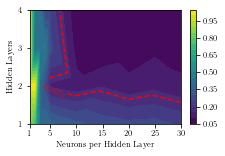

Samples: 100


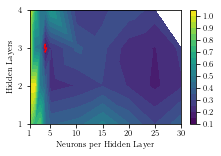

Samples: 10000


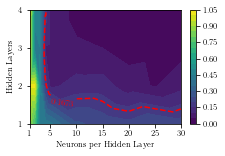

In [6]:
highlight_lvl = 0.16725606071380222

for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[2], levels=20)
    cs2 = ax.tricontour(values[0], values[1], values[2], levels=[highlight_lvl], colors='r')
    cs2.collections[0].set_linestyle('dashed')
    ax.clabel(cs2, cs2.levels, inline=True, fontsize=8)
    fig.colorbar(cs)
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/approximation_error_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


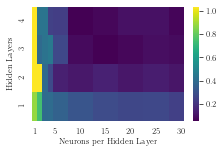

Samples: 100


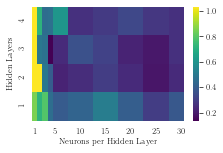

Samples: 10000


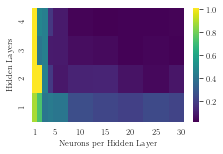

In [7]:
highlight_lvl = 0.16725606071380222

for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    x_axis_labels = np.arange(np.min(values[0]), np.max(values[0]) + 1)
    y_axis_labels = np.arange(np.min(values[1]), np.max(values[1]) + 1)
    data = np.zeros((len(x_axis_labels), len(y_axis_labels)))
    for i in range(values.shape[1]):
        data[int(values[0, i] - np.min(values[0])), int(values[1, i] - np.min(values[1]))] = values[2, i]
        
    x_axis_labels = [(int(x) if x in [1, 5, 10, 15, 20, 25, 30] else None) for x in x_axis_labels]
    y_axis_labels = [(int(x) if x in [1, 2, 3, 4] else None) for x in y_axis_labels]
    mask = np.zeros_like(data, dtype=bool)
    mask[data == 0] = True
    
    data = interpolate_missing_pixels(data, mask)
    
    with sns.axes_style('white'):
        sns.heatmap(np.flip(data, axis=1).T, xticklabels=x_axis_labels, yticklabels=np.flip(y_axis_labels), rasterized=True, cmap='viridis')
    plt.xlabel('Neurons per Hidden Layer')
    plt.ylabel('Hidden Layers')
    plt.savefig(f'figures/approximation_error_{samples}.pdf', dpi=500, bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


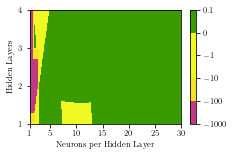

Samples: 100


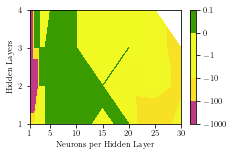

Samples: 10000


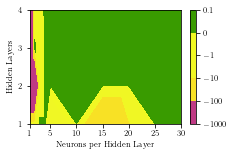

In [8]:
viridis = cm.get_cmap('plasma', 10000)
newcolors = viridis(np.linspace(0, 1, 10000))
green = np.array([57/256, 156/256, 0/256, 1])
newcolors[9999:, :] = green
newcmp = ListedColormap(newcolors)

for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[3], levels=[-1000, -100, -10, -1, -1e-4, 0.1], cmap=newcmp)
    cbar = fig.colorbar(cs)
    cbar.ax.set_yticklabels([r'$-1000$', r'$-100$', r'$-10$', r'$-1$', r'$0$', r'$0.1$'])
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/verify_stability_sufficient_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


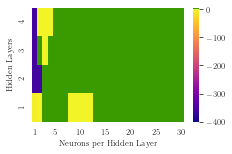

Samples: 100


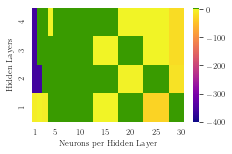

Samples: 10000


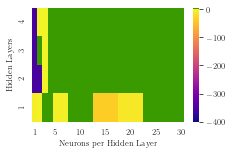

In [9]:
viridis = cm.get_cmap('plasma', 1000000)
newcolors = viridis(np.linspace(0, 1, 1000000))
green = np.array([57/256, 156/256, 0/256, 1])
newcolors[987654:, :] = green
newcmp = ListedColormap(newcolors)

for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    x_axis_labels = np.arange(np.min(values[0]), np.max(values[0]) + 1)
    y_axis_labels = np.arange(np.min(values[1]), np.max(values[1]) + 1)
    data = np.zeros((len(x_axis_labels), len(y_axis_labels)))
    for i in range(values.shape[1]):
        data[int(values[0, i] - np.min(values[0])), int(values[1, i] - np.min(values[1]))] = values[3, i]
        
    x_axis_labels = [(int(x) if x in [1, 5, 10, 15, 20, 25, 30] else None) for x in x_axis_labels]
    y_axis_labels = [(int(x) if x in [1, 2, 3, 4] else None) for x in y_axis_labels]
    mask = np.zeros_like(data, dtype=bool)
    mask[data == 0] = True
    
    data = interpolate_missing_pixels(data, mask)
    
    with sns.axes_style('white'):
        sns.heatmap(np.flip(data, axis=1).T, xticklabels=x_axis_labels, yticklabels=np.flip(y_axis_labels), rasterized=True, cmap=newcmp, vmin=-400, vmax=5)
    plt.xlabel('Neurons per Hidden Layer')
    plt.ylabel('Hidden Layers')
    plt.savefig(f'figures/verify_stability_sufficient_{samples}.pdf', dpi=500, bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


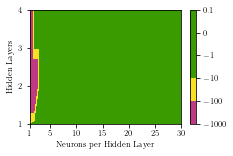

Samples: 100


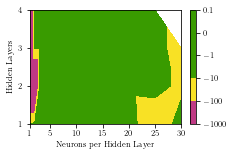

Samples: 10000


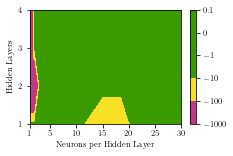

In [10]:
for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[4], levels=[-1000, -100, -10, -1, -1e-4, 0.1], cmap=newcmp)
    cbar = fig.colorbar(cs)
    cbar.ax.set_yticklabels([r'$-1000$', r'$-100$', r'$-10$', r'$-1$', r'$0$', r'$0.1$'])
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/verify_stability_direct_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


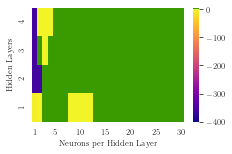

Samples: 100


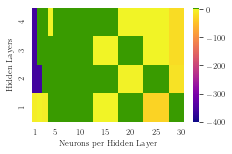

Samples: 10000


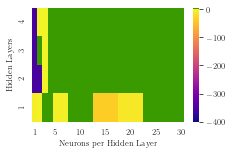

In [11]:
for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    x_axis_labels = np.arange(np.min(values[0]), np.max(values[0]) + 1)
    y_axis_labels = np.arange(np.min(values[1]), np.max(values[1]) + 1)
    data = np.zeros((len(x_axis_labels), len(y_axis_labels)))
    for i in range(values.shape[1]):
        data[int(values[0, i] - np.min(values[0])), int(values[1, i] - np.min(values[1]))] = values[4, i]
        
    x_axis_labels = [(int(x) if x in [1, 5, 10, 15, 20, 25, 30] else None) for x in x_axis_labels]
    y_axis_labels = [(int(x) if x in [1, 2, 3, 4] else None) for x in y_axis_labels]
    mask = np.zeros_like(data, dtype=bool)
    mask[data == 0] = True
    
    data = interpolate_missing_pixels(data, mask)
    
    with sns.axes_style('white'):
        sns.heatmap(np.flip(data, axis=1).T, xticklabels=x_axis_labels, yticklabels=np.flip(y_axis_labels), rasterized=True, cmap=newcmp, vmin=-400, vmax=5)
    plt.xlabel('Neurons per Hidden Layer')
    plt.ylabel('Hidden Layers')
    plt.savefig(f'figures/verify_stability_direct_{samples}.pdf', dpi=500, bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


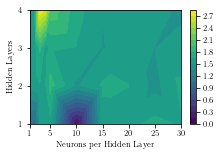

Samples: 100


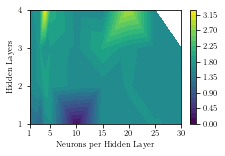

Samples: 10000


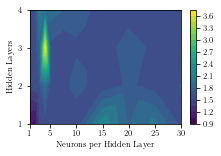

In [12]:
for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[5], levels=20)
    fig.colorbar(cs)
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/approximation_error_lipschitz_constant_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


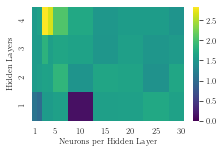

Samples: 100


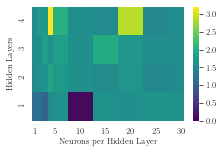

Samples: 10000


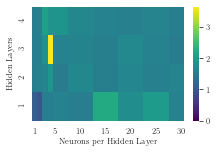

In [13]:
for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    x_axis_labels = np.arange(np.min(values[0]), np.max(values[0]) + 1)
    y_axis_labels = np.arange(np.min(values[1]), np.max(values[1]) + 1)
    data = np.zeros((len(x_axis_labels), len(y_axis_labels)))
    for i in range(values.shape[1]):
        data[int(values[0, i] - np.min(values[0])), int(values[1, i] - np.min(values[1]))] = values[5, i]
        
    x_axis_labels = [(int(x) if x in [1, 5, 10, 15, 20, 25, 30] else None) for x in x_axis_labels]
    y_axis_labels = [(int(x) if x in [1, 2, 3, 4] else None) for x in y_axis_labels]
    mask = np.zeros_like(data, dtype=bool)
    mask[data == 0] = True
    
    data = interpolate_missing_pixels(data, mask)
    
    with sns.axes_style('white'):
        sns.heatmap(np.flip(data, axis=1).T, xticklabels=x_axis_labels, yticklabels=np.flip(y_axis_labels), rasterized=True, cmap='viridis', vmin=0)
    plt.xlabel('Neurons per Hidden Layer')
    plt.ylabel('Hidden Layers')
    plt.savefig(f'figures/approximation_error_lipschitz_constant_{samples}.pdf', dpi=500, bbox_inches='tight', pad_inches=0.03)
    plt.show()